In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, ensemble
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
from xgboost import XGBClassifier, plot_importance
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
import pickle
from copy import copy, deepcopy
from datetime import date, datetime
import warnings

datapath = '../data/insurance_churn/'

churn_dt = pd.read_csv(datapath + 'autoinsurance_churn.csv')
address_dt = pd.read_csv(datapath + 'address.csv')
demographic_dt = pd.read_csv(datapath + 'demographic.csv')
customer_dt = pd.read_csv(datapath + 'customer.csv')
termination_dt = pd.read_csv(datapath + 'termination.csv')

In [190]:
address_columns = [str.lower() for str in address_dt.columns.to_list()]
demographic_columns = [str.lower() for str in demographic_dt.columns.to_list()]
customer_columns = [str.lower() for str in customer_dt.columns.to_list()]
termination_columns = [str.lower() for str in termination_dt.columns.to_list()]

address_dt.columns = address_columns
demographic_dt.columns = demographic_columns
customer_dt.columns = customer_columns
termination_dt.columns = termination_columns

churn_dt_orig = churn_dt.copy()
customer_dt_orig = customer_dt.copy()

# drop address information first
churn_dt = churn_dt_orig.drop(address_dt.columns[address_dt.columns.isin(churn_dt.columns.values)], axis=1)

# drop date of birth due to overlapping with age in years, and SSN
churn_dt = churn_dt.drop(['date_of_birth'], axis=1)
customer_dt = customer_dt_orig.drop(['date_of_birth', 'social_security_number', 'address_id'], axis=1)


In [191]:
# Simple decriptive analysis:
print(f'There are {churn_dt['individual_id'].size} customer IDs and {churn_dt['individual_id'].unique().size} unique IDs in (full) churn data')
print(f'There are {demographic_dt['individual_id'].size} customer IDs and {demographic_dt['individual_id'].unique().size} unique IDs in demographic data')
print(f'There are {customer_dt['individual_id'].size} customer IDs and {customer_dt['individual_id'].unique().size} unique IDs in customer data')
print(f'There are {termination_dt['individual_id'].size} customer IDs and {termination_dt['individual_id'].unique().size} unique IDs in termination data')
print(f'{np.sum(churn_dt['individual_id'].isin(customer_dt['individual_id']))} of {churn_dt['individual_id'].size} individual IDs are in customer_dt')
print(f'{np.sum(churn_dt['individual_id'].isin(demographic_dt['individual_id']))} of {churn_dt['individual_id'].size} individual IDs are in demographic_dt')
print(f'{np.sum(churn_dt['individual_id'].isin(termination_dt['individual_id']))} of {churn_dt['individual_id'].size} individual IDs are in termination_dt')

# Make sure all IDs are sorted in an ascending order
#churn_dt.iloc([churn_dt['individual_id'].sort_values().index])
churn_dt = churn_dt.iloc[churn_dt['individual_id'].argsort()]
customer_dt = customer_dt.iloc[customer_dt['individual_id'].notna().values]
customer_dt = customer_dt.iloc[customer_dt['individual_id'].argsort()]
demographic_dt = demographic_dt.iloc[demographic_dt['individual_id'].argsort()]
termination_dt = termination_dt.iloc[termination_dt['individual_id'].argsort()]

customer_dt_in_churn = customer_dt.iloc[customer_dt['individual_id'].isin(churn_dt['individual_id']).values]
customer_dt_notin_churn = customer_dt.iloc[(customer_dt['individual_id'].isin(churn_dt['individual_id'])==False).values]

demographic_dt_in_churn = demographic_dt.iloc[demographic_dt['individual_id'].isin(churn_dt['individual_id']).values]
demographic_dt_notin_churn = demographic_dt.iloc[(demographic_dt['individual_id'].isin(churn_dt['individual_id'])==False).values]

termination_dt_in_churn = termination_dt.iloc[termination_dt['individual_id'].isin(churn_dt['individual_id']).values]
termination_dt_notin_churn = termination_dt.iloc[(termination_dt['individual_id'].isin(churn_dt['individual_id'])==False).values]

churn_dt_in_customer = churn_dt[customer_dt.columns]
churn_dt_in_demographic = churn_dt[demographic_dt.columns]
churn_dt_in_termination = churn_dt[termination_dt.columns].iloc[churn_dt['individual_id'].isin(termination_dt['individual_id']).values]

# make sure the common part is correct and no missing value in the full churn data
if np.max(abs(customer_dt_in_churn[['curr_ann_amt','days_tenure']].values - churn_dt_in_customer[['curr_ann_amt','days_tenure']].values)):
    print("Customer data and full data is inconsistent in [current annuity amount] and [days tenure] columns")
else:
    print("Customer data and full data is consistent in [current annuity amount] and [days tenure] columns")

if np.array_equal(customer_dt_in_churn['cust_orig_date'].values, churn_dt_in_customer['cust_orig_date'].values):
    print("Common part over customer and full data is consistent in [cust_orig_date]")
else:
    print("Common part over customer and full data is inconsistent in [cust_orig_date]")
    
if np.sum(churn_dt_in_customer[['age_in_years']].isna().values):
    print("Common part over customer and full data in [age in years] has missing values.")
else:
    print("Common part over customer and full data in [age in years] has no missing values.")

if np.max(abs(churn_dt_in_demographic['income'].values - demographic_dt_in_churn['income'].values)):
    print("Common part over demographic and full data is inconsistent in [income]")
else:
    print("Common part over demographic and full data is consistent in [income]")
    
if churn_dt_in_demographic['income'].isna().values.sum():
    print("Common part over demographic and full data in [income] has missing values")
else:
    print("Common part over demographic and full data in [income] has no missing values")

if np.max(abs(churn_dt_in_demographic[['has_children','length_of_residence','home_owner','college_degree']].values - 
            demographic_dt_in_churn[['has_children','length_of_residence','home_owner','college_degree']].values)):
    print("Common part over demographic and full data in [has_children, length_of_residence, home_owner, college_degree] has missing values")
else:
    print("Common part over demographic and full data in [has_children, length_of_residence, home_owner, college_degree] has no missing values")

if churn_dt_in_demographic[['has_children','length_of_residence','home_owner','college_degree']].isna().values.sum():
    print("Common part over demographic and full data is inconsistent in [has_children, length_of_residence, home_owner, college_degree]")

if np.array_equal(churn_dt_in_demographic[['marital_status']].values,  demographic_dt_in_churn[['marital_status']].values):
    print("Common part over demographic and full data is consistent in [marital_status]")
else:
    print("Common part over demographic and full data is inconsistent in [marital_status]")
    
if churn_dt_in_demographic[['marital_status']].isna().values.sum():
    print("Common part over demographic and full data in [marital_status] has missing values")
else:
    print("Common part over demographic and full data in [marital_status] has no missing values")

if np.array_equal(churn_dt_in_demographic[['home_market_value']].values, demographic_dt_in_churn[['home_market_value']].values):
    print("Common part over demographic and full data is consistent in [home_market_value]")
else:
    print("Common part over demographic and full data is inconsistent in [home_market_value]")
    
if churn_dt_in_demographic[['home_market_value']].isna().values.sum():
    print("Common part over demographic and full data in [home_market_value] has missing values")
else:
    print("Common part over demographic and full data in [home_market_value] has no missing values")

if np.array_equal(churn_dt_in_demographic['home_market_value'][(churn_dt_in_demographic['home_market_value'].isna()==False).values].values, 
            demographic_dt_in_churn['home_market_value'][(churn_dt_in_demographic['home_market_value'].isna()==False).values].values):
    print("Common part over demographic and full data is consistent in [home_market_value] where full data has no missing values")
else:
    print("Common part over demographic and full data is inconsistent in [home_market_value] where full data has no missing values")
    
if demographic_dt_in_churn['home_market_value'][(churn_dt_in_demographic['home_market_value'].isna()==True).values].isna().sum():
    print("Common part over demographic data in [home_market_value] has missing values where full data has missing values")
else:
    print("Common part over demographic data in [home_market_value] has no missing values where full data has missing values")

if np.array_equal(termination_dt_in_churn['acct_suspd_date'].values, churn_dt_in_termination['acct_suspd_date'].values):
    print("Common part over termination and full data is consistent in [acct_suspd_date]")
else:
    print("Common part over termination and full data is inconsistent in [acct_suspd_date]")

# Now make patches to the existing (full) churn data
common_ids_patch = customer_dt_notin_churn['individual_id'][customer_dt_notin_churn['individual_id'].isin(demographic_dt_notin_churn['individual_id'])]
customer_dt_patch = customer_dt_notin_churn.iloc[customer_dt_notin_churn['individual_id'].isin(demographic_dt_notin_churn['individual_id']).values]
demographic_dt_patch = demographic_dt_notin_churn.iloc[demographic_dt_notin_churn['individual_id'].isin(customer_dt_patch['individual_id']).values]
np.max(abs(customer_dt_patch['individual_id'].values - demographic_dt_patch['individual_id'].values))
termination_dt_patch = termination_dt_notin_churn.iloc[termination_dt_notin_churn['individual_id'].isin(common_ids_patch).values]
termination_dt_patch.size, common_ids_patch.size

body_patch = np.hstack((customer_dt_patch.values, demographic_dt_patch.drop(['individual_id'], axis=1).values))
churn_dt_patch = pd.DataFrame(data=body_patch, columns=np.concatenate((customer_dt_patch.columns.to_numpy(), demographic_dt.drop(['individual_id'], axis=1).columns.to_numpy()), axis=0))

churn_dt_patch['acct_suspd_date'] = np.nan
churn_dt_patch['acct_suspd_date'] = churn_dt_patch['acct_suspd_date'].to_numpy(dtype=object)
churn_dt_patch.loc[churn_dt_patch['individual_id'].isin(termination_dt_patch['individual_id']).values, 'acct_suspd_date'] = termination_dt_patch.loc[termination_dt_patch['individual_id'].isin(churn_dt_patch['individual_id']).values, 'acct_suspd_date'].to_numpy()

churn_dt_patch['Churn'] = 0
churn_dt_patch.loc[churn_dt_patch['individual_id'].isin(termination_dt_patch['individual_id']).values, 'Churn'] = 1

if churn_dt_patch['marital_status'].isna().sum() == churn_dt_patch['marital_status'].size:
    print("OK, find the marital status data in the churn_dt_patch is missing. Now only use the churn_dt data")

There are 1680909 customer IDs and 1680909 unique IDs in (full) churn data
There are 2112579 customer IDs and 2112579 unique IDs in demographic data
There are 2280321 customer IDs and 2280321 unique IDs in customer data
There are 269259 customer IDs and 269259 unique IDs in termination data
1680909 of 1680909 individual IDs are in customer_dt
1680909 of 1680909 individual IDs are in demographic_dt
193456 of 1680909 individual IDs are in termination_dt
Customer data and full data is consistent in [current annuity amount] and [days tenure] columns
Common part over customer and full data is consistent in [cust_orig_date]
Common part over customer and full data in [age in years] has no missing values.
Common part over demographic and full data is consistent in [income]
Common part over demographic and full data in [income] has no missing values
Common part over demographic and full data in [has_children, length_of_residence, home_owner, college_degree] has no missing values
Common part ove

In [192]:
## Now preprocessing the data

# 0. change "marrital status" to binary, change days_tenure to years_tenure
churn_dt_b4_use = churn_dt.copy()
churn_dt['married'] = 0
churn_dt.loc[churn_dt_b4_use['marital_status'] == 'Married', 'married'] = 1
churn_dt = churn_dt_b4_use.drop(['marital_status'], axis=1)
churn_dt['years_tenure'] = churn_dt['days_tenure'].values/365

# 1. Seems that days tenure are calculated based on the end date, which is "today", 2022-12-2 (Needs proof)
lastday = pd.to_datetime('2022-12-02', format='%Y-%m-%d')

cust_orig_dates = pd.to_datetime(churn_dt.loc[:, 'cust_orig_date'], format='%Y-%m-%d')
ddd = lastday - cust_orig_dates
dddays = pd.to_timedelta(ddd.values, 'days').days
if (dddays - churn_dt.loc[:, 'days_tenure']).abs().max() == 0:
    print("It is confirmed that today is 2022-12-02")

# 2. If the opening date is AFTER the suspension date, change the suspension date to "NA", and change the "Churn" indicator to 0    
# 3. If the opening date is BEFORE or AT the suspension date, may need to change "days_tenure" to the interval between the opening date and the suspension date
churn_dt_suspd = churn_dt.loc[churn_dt['acct_suspd_date'].isna()==False, ['days_tenure', 'cust_orig_date', 'acct_suspd_date', 'Churn']]
churn_dt_suspd = pd.DataFrame(data=churn_dt_suspd.values, columns=churn_dt_suspd.columns)
dates_orig = pd.to_datetime(churn_dt_suspd['cust_orig_date'], format='%Y-%m-%d')
dates_suspd = pd.to_datetime(churn_dt_suspd['acct_suspd_date'], format='%Y-%m-%d')
churn_dt_suspd.loc[dates_orig > dates_suspd, 'acct_suspd_date'] = np.nan
churn_dt_suspd.loc[dates_orig > dates_suspd, 'Churn'] = 0
churn_dt_suspd.loc[dates_orig <= dates_suspd, 'days_tenure'] = pd.to_timedelta(dates_suspd.loc[dates_orig <= dates_suspd].values - dates_orig.loc[dates_orig <= dates_suspd].values, 'days').days

churn_dt_suspd.head(5)
churn_dt.loc[churn_dt['acct_suspd_date'].isna()==False, ['days_tenure', 'cust_orig_date', 'acct_suspd_date', 'Churn']] = churn_dt_suspd.values

# Reshape the data, reordering the indices
churn_dt_b4_reshuffle = churn_dt.copy()
churn_dt = pd.DataFrame(data=churn_dt_b4_reshuffle.values, columns = churn_dt_b4_reshuffle.columns)
#churn_dt.head(25)

# 4. Add a new dummy column where 'cust_orig_date' at '2005-09-11' named orig_b4_050911
churn_dt['orig_b4_050911'] = 0
#churn_dt.drop(churn_dt['cust_orig_date'][churn_dt['cust_orig_date'] == '2005-09-11'].index, axis=0, inplace=True)
churn_dt.loc[churn_dt['cust_orig_date'] == '2005-09-11', 'orig_b4_050911'] = 1
print(churn_dt.columns)

# 5. Some housing_market_value == nan. First try adding a separte columns for it
churn_dt_HMV = churn_dt.copy()
# churn_dt['HMV_unknown'] = 0
# churn_dt.loc[churn_dt_HMV['home_market_value'].isna(),'HMV_unknown'] = 1
# churn_dt.loc[churn_dt_HMV['home_market_value'].isna(), 'home_market_value'] = 'unknown'
churn_dt.drop(churn_dt_HMV['home_market_value'][churn_dt_HMV['home_market_value'].isna()].index, axis=0, inplace=True)
print(churn_dt.columns)
churn_dt = pd.DataFrame(data=churn_dt.values, columns=churn_dt.columns)

# 6. drop a few string columns and the id column
churn_dt.drop(['individual_id', 'cust_orig_date', 'acct_suspd_date'], axis=1, inplace=True)
print(churn_dt.shape)
print(churn_dt.columns)

# 7. Now deal with home_market_value
print(churn_dt['home_market_value'].unique())
HMV_dict = {
    'unknown': 0,
    '1000 - 24999': 0,
    '25000 - 49999': 1,
    '50000 - 74999': 2,
    '75000 - 99999': 3,
    '100000 - 124999': 4,
    '125000 - 149999': 5,
    '150000 - 174999': 6,
    '175000 - 199999': 7,
    '200000 - 224999': 8,
    '225000 - 249999': 9,
    '250000 - 274999': 10,
    '275000 - 299999': 11,
    '300000 - 349999': 12,
    '350000 - 399999': 13,
    '400000 - 449999': 14,
    '450000 - 499999': 15,
    '500000 - 749999': 16,
    '750000 - 999999': 17,
    '1000000 Plus': 18
}

def mapping_hmv_to_int(s):
    return HMV_dict.get(s)

mapping_vhmv_to_int = np.vectorize(mapping_hmv_to_int)
#mapping_vhmv_to_int(churn_dt['home_market_value'].values)
churn_dt['home_value_class'] = mapping_vhmv_to_int(churn_dt['home_market_value'].values)
churn_dt.head(5)

# Final preparation before splitting
y = churn_dt['Churn'].astype('int64')
X = churn_dt.copy()
X = X.drop(['Churn', 'home_market_value', 'days_tenure'], axis=1)

It is confirmed that today is 2022-12-02
Index(['individual_id', 'curr_ann_amt', 'days_tenure', 'cust_orig_date',
       'age_in_years', 'income', 'has_children', 'length_of_residence',
       'home_market_value', 'home_owner', 'college_degree', 'good_credit',
       'acct_suspd_date', 'Churn', 'years_tenure', 'orig_b4_050911'],
      dtype='object')
Index(['individual_id', 'curr_ann_amt', 'days_tenure', 'cust_orig_date',
       'age_in_years', 'income', 'has_children', 'length_of_residence',
       'home_market_value', 'home_owner', 'college_degree', 'good_credit',
       'acct_suspd_date', 'Churn', 'years_tenure', 'orig_b4_050911'],
      dtype='object')
(1588623, 13)
Index(['curr_ann_amt', 'days_tenure', 'age_in_years', 'income', 'has_children',
       'length_of_residence', 'home_market_value', 'home_owner',
       'college_degree', 'good_credit', 'Churn', 'years_tenure',
       'orig_b4_050911'],
      dtype='object')
['500000 - 749999' '125000 - 149999' '100000 - 124999' '1000000

In [193]:
# Use minmax scaler for all columns of X
minmax = MinMaxScaler((0.001, 1))
X = pd.DataFrame(data=minmax.fit(X).transform(X), columns = X.columns)
X.head(5)

,curr_ann_amt,age_in_years,income,has_children,length_of_residence,home_owner,college_degree,good_credit,years_tenure,orig_b4_050911,home_value_class
0,0.419567,0.396209,0.490306,1.000,0.1342,1.0,0.001,1.0,0.714048,0.001,0.8890
1,0.361656,0.462077,0.266041,1.000,0.4672,1.0,1.000,1.0,1.000000,1.000,0.2785
2,0.525245,0.132736,0.337398,0.001,0.2008,1.0,0.001,1.0,0.085272,0.001,0.2230
3,0.563301,0.505989,0.490306,1.000,0.7336,1.0,0.001,1.0,0.027604,0.001,0.2785
4,0.305158,0.484033,0.337398,0.001,0.6004,1.0,0.001,1.0,0.254454,0.001,0.2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919068 entries, 0 to 2919067
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   curr_ann_amt         float64
 1   age_in_years         float64
 2   income               float64
 3   has_children         float64
 4   length_of_residence  float64
 5   home_owner           float64
 6   college_degree       float64
 7   good_credit          float64
 8   years_tenure         float64
 9   orig_b4_050911       float64
 10  home_value_class     float64
dtypes: float64(11)
memory usage: 245.0 MB


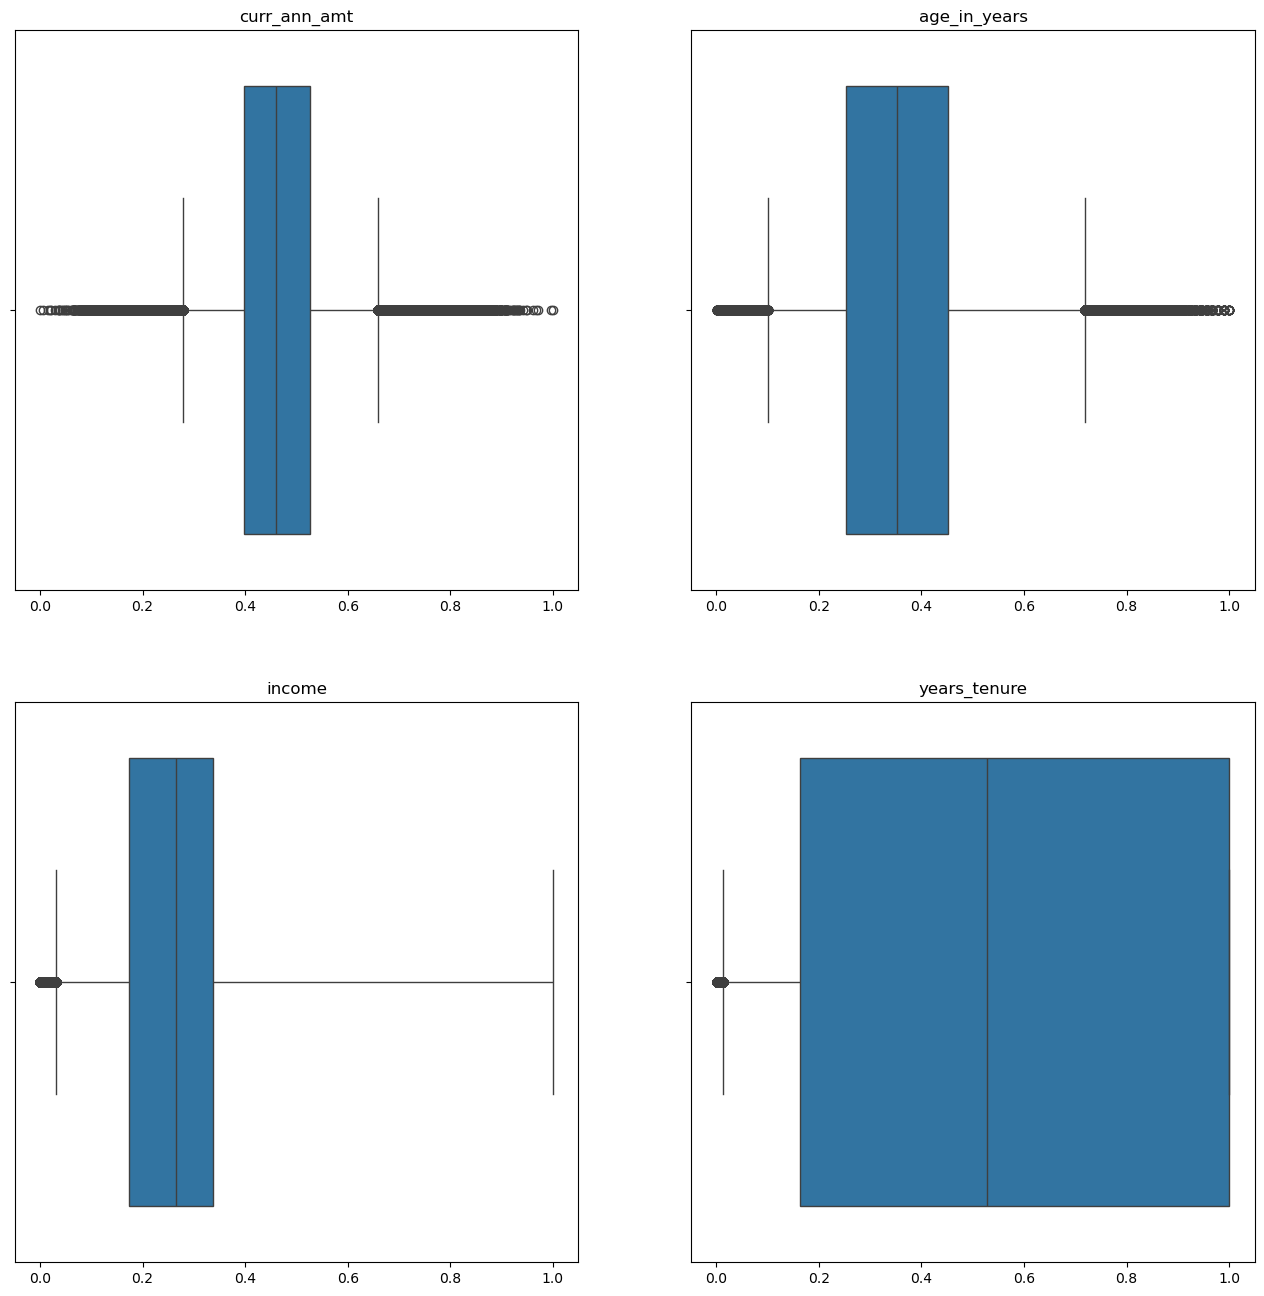

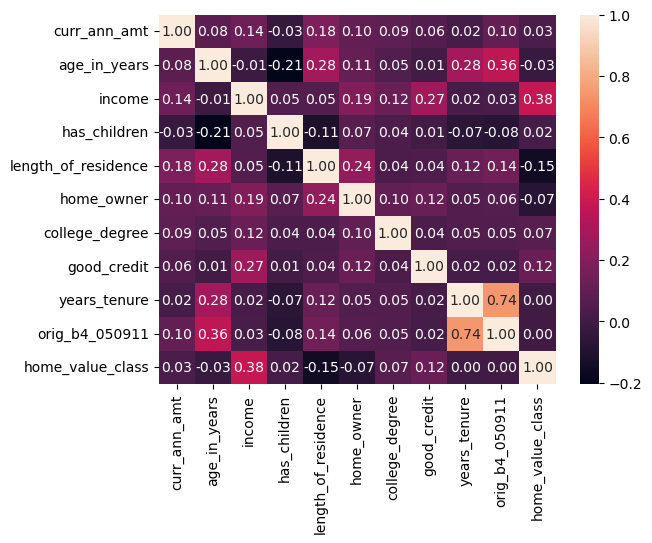

In [194]:
# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_resamp, y_resamp = smote.fit_resample(X, y)

# Do some decriptive analysis
X_resamp.info()
X_resamp = X_resamp.astype('float')
X_resamp.describe()

# Check outliers
check_otl_columns = ['curr_ann_amt', 'age_in_years', 'income', 'years_tenure']

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for ji in range(len(check_otl_columns)):
    pos_v = ji // 2
    pos_h = ji % 2
    sns.boxplot(X_resamp[check_otl_columns[ji]], orient='h', whis=(2.5, 97.5), ax=axes[pos_v, pos_h])
    axes[pos_v, pos_h].set_title(check_otl_columns[ji])
    axes[pos_v, pos_h].set_xlabel('')
    axes[pos_v, pos_h].set_ylabel('')
plt.show()

# Plot correlations
fig = plt.plot(figsize=(20, 20))
sns.heatmap(X_resamp.corr(), annot=True, fmt='.2f')
plt.show()

In [195]:
# Split into training and test sets
X_resampled, X_test, y_resampled, y_test = train_test_split(X_resamp, y_resamp, test_size=0.2, random_state=42)

X_resampled_dropped = X_resampled[['curr_ann_amt', 'income']]
X_resampled = X_resampled.drop(['curr_ann_amt', 'income'], axis=1)

In [196]:
Cvals = [10.0, 1000.0, 1000000.0]
logit = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, random_state=42, solver='lbfgs', max_iter=1000, verbose=1, warm_start=True)
logit.fit(X_resampled, y_resampled)
if logit.n_iter_ < logit.max_iter:
    print(f"Ridge logit model with C={logit.C} converges in {logit.n_iter_[0]} iterations.")
else:
    print("Ridge logit model with C={logit.C} does NOT converge.")
print(logit.coef_)

for cv in Cvals:
    logit.C = cv
    logit.fit(X_resampled, y_resampled)
    if logit.n_iter_ < logit.max_iter:
        print(f"Ridge logit model with C={logit.C} converges in {logit.n_iter_[0]} iterations.")
    else:
        print("Ridge logit model with C={logit.C} does NOT converge.")
    print(logit.coef_)

warnings.filterwarnings("ignore")

logit.penalty=None
logit.fit(X_resampled, y_resampled)
if logit.n_iter_ < logit.max_iter:
    print(f"Unregulated logit model converges in {logit.n_iter_[0]} iterations.")
else:
    print("Unregulated logit model does NOT converge.")
print(logit.coef_)

warnings.filterwarnings("default")

Ridge logit model with C=1.0 converges in 16 iterations.
[[ 0.1961824   0.0543491  -0.13132294  0.0355148  -0.05835966 -0.03228896
  -0.82758207  0.29249082 -0.09328168]]
Ridge logit model with C=10.0 converges in 0 iterations.
[[ 0.1961824   0.0543491  -0.13132294  0.0355148  -0.05835966 -0.03228896
  -0.82758207  0.29249082 -0.09328168]]
Ridge logit model with C=1000.0 converges in 0 iterations.
[[ 0.1961824   0.0543491  -0.13132294  0.0355148  -0.05835966 -0.03228896
  -0.82758207  0.29249082 -0.09328168]]
Ridge logit model with C=1000000.0 converges in 0 iterations.
[[ 0.1961824   0.0543491  -0.13132294  0.0355148  -0.05835966 -0.03228896
  -0.82758207  0.29249082 -0.09328168]]
Unregulated logit model converges in 0 iterations.
[[ 0.1961824   0.0543491  -0.13132294  0.0355148  -0.05835966 -0.03228896
  -0.82758207  0.29249082 -0.09328168]]


In [197]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [198]:
X_resampled['curr_ann_amt'] = np.log(X_resampled_dropped['curr_ann_amt'].astype('float').values)
print(X_resampled.columns)

logit = LogisticRegression(penalty=None, tol=0.0001, C=1.0, fit_intercept=True, random_state=42, solver='lbfgs', max_iter=1000, verbose=1, warm_start=True)
logit.fit(X_resampled, y_resampled)
if logit.n_iter_ < logit.max_iter:
    print(f"Unregulated logit model with [curr_ann_amt] added converges in {logit.n_iter_[0]} iterations.")
else:
    print("Unregulated logit model with [curr_ann_amt] added does NOT converge.")
print(logit.coef_)

Index(['age_in_years', 'has_children', 'length_of_residence', 'home_owner',
       'college_degree', 'good_credit', 'years_tenure', 'orig_b4_050911',
       'home_value_class', 'curr_ann_amt'],
      dtype='object')
Unregulated logit model with [curr_ann_amt] added converges in 18 iterations.
[[ 0.20352582  0.05520072 -0.14926588  0.03093742 -0.06343661 -0.032753
  -0.81171488  0.27664126 -0.10146119  0.15816275]]


In [199]:
X_resampled['income'] = np.log(X_resampled_dropped['income'].astype('float').values)
print(X_resampled.columns)

logit = LogisticRegression(penalty=None, tol=0.0001, C=1.0, fit_intercept=True, random_state=42, solver='lbfgs', max_iter=10000, verbose=1, warm_start=True)
logit.fit(X_resampled, y_resampled)
if logit.n_iter_ < logit.max_iter:
    print(f"Unregulated logit model with all columns converges in {logit.n_iter_[0]} iterations.")
else:
    print("Unregulated logit model with all columns does NOT converge.")
print(logit.coef_)

Index(['age_in_years', 'has_children', 'length_of_residence', 'home_owner',
       'college_degree', 'good_credit', 'years_tenure', 'orig_b4_050911',
       'home_value_class', 'curr_ann_amt', 'income'],
      dtype='object')
Unregulated logit model with all columns converges in 18 iterations.
[[ 0.22691013  0.05673736 -0.14709389  0.00908647 -0.06593037 -0.07856289
  -0.81374672  0.2757033  -0.18974072  0.14239835  0.04820436]]


In [200]:
# Store regression results into dictionary
reg_results = {}
for j in range(X_resampled.columns.size):
    reg_results[X_resampled.columns[j]] = logit.coef_.squeeze()[j]
reg_results_0 = reg_results.copy()
reg_results['intercept'] = logit.intercept_[0]
print(reg_results)

# Error analysis
y1_resampled_pred = X_resampled.values @ logit.coef_.T + logit.intercept_
dy_resampled = -y1_resampled_pred

# Perform Wald test
def get_coef_wald_test(X, model):
    proba = model.predict_proba(X)
    p = proba[:,0]
    n = len(p)
    ncoef = model.coef_.size
    if model.fit_intercept:
        X = np.hstack((X.values, np.ones((n,1))))
        ncoef = ncoef + 1
    v = p*(1-p)
    Xv = np.zeros((n, int(ncoef)))
    for j in range(ncoef):
        Xv[:,j] = X[:,j] * v
    ivcov = Xv.transpose() @ X
    vcov = np.linalg.inv(ivcov.astype('float'))
    se = np.sqrt(np.diag(vcov).astype('float'))
    coefs = np.concatenate((model.coef_.squeeze(), model.intercept_))
    W =  coefs/se  # Wald test statistics
    pvalue = (1 - norm.cdf(abs(W))) * 2
    return W, pvalue

W, pvalue = get_coef_wald_test(X_resampled, logit)
print(pvalue)

# Put test results into result dictionary
reg_results['p-values'] = {}
reg_results['z-stats'] = {}
for j in range(reg_results.keys().__len__()-3):
    reg_results['p-values'][list(reg_results.keys())[j]] = pvalue[j+1]
    reg_results['z-stats'][list(reg_results.keys())[j]] = W[j+1]

reg_results['p-values']['intercept'] = pvalue[0]
reg_results['z-stats']['intercept'] = W[0]

{'age_in_years': 0.2269101327586103, 'has_children': 0.05673736162743699, 'length_of_residence': -0.14709389247926896, 'home_owner': 0.009086469156935716, 'college_degree': -0.06593037400501671, 'good_credit': -0.07856288928205564, 'years_tenure': -0.8137467239029688, 'orig_b4_050911': 0.2757033045225738, 'home_value_class': -0.18974071999415132, 'curr_ann_amt': 0.14239834827718081, 'income': 0.048204361621534055, 'intercept': 0.6392005833899332}
[0.         0.         0.         0.02749865 0.         0.
 0.         0.         0.         0.         0.         0.        ]


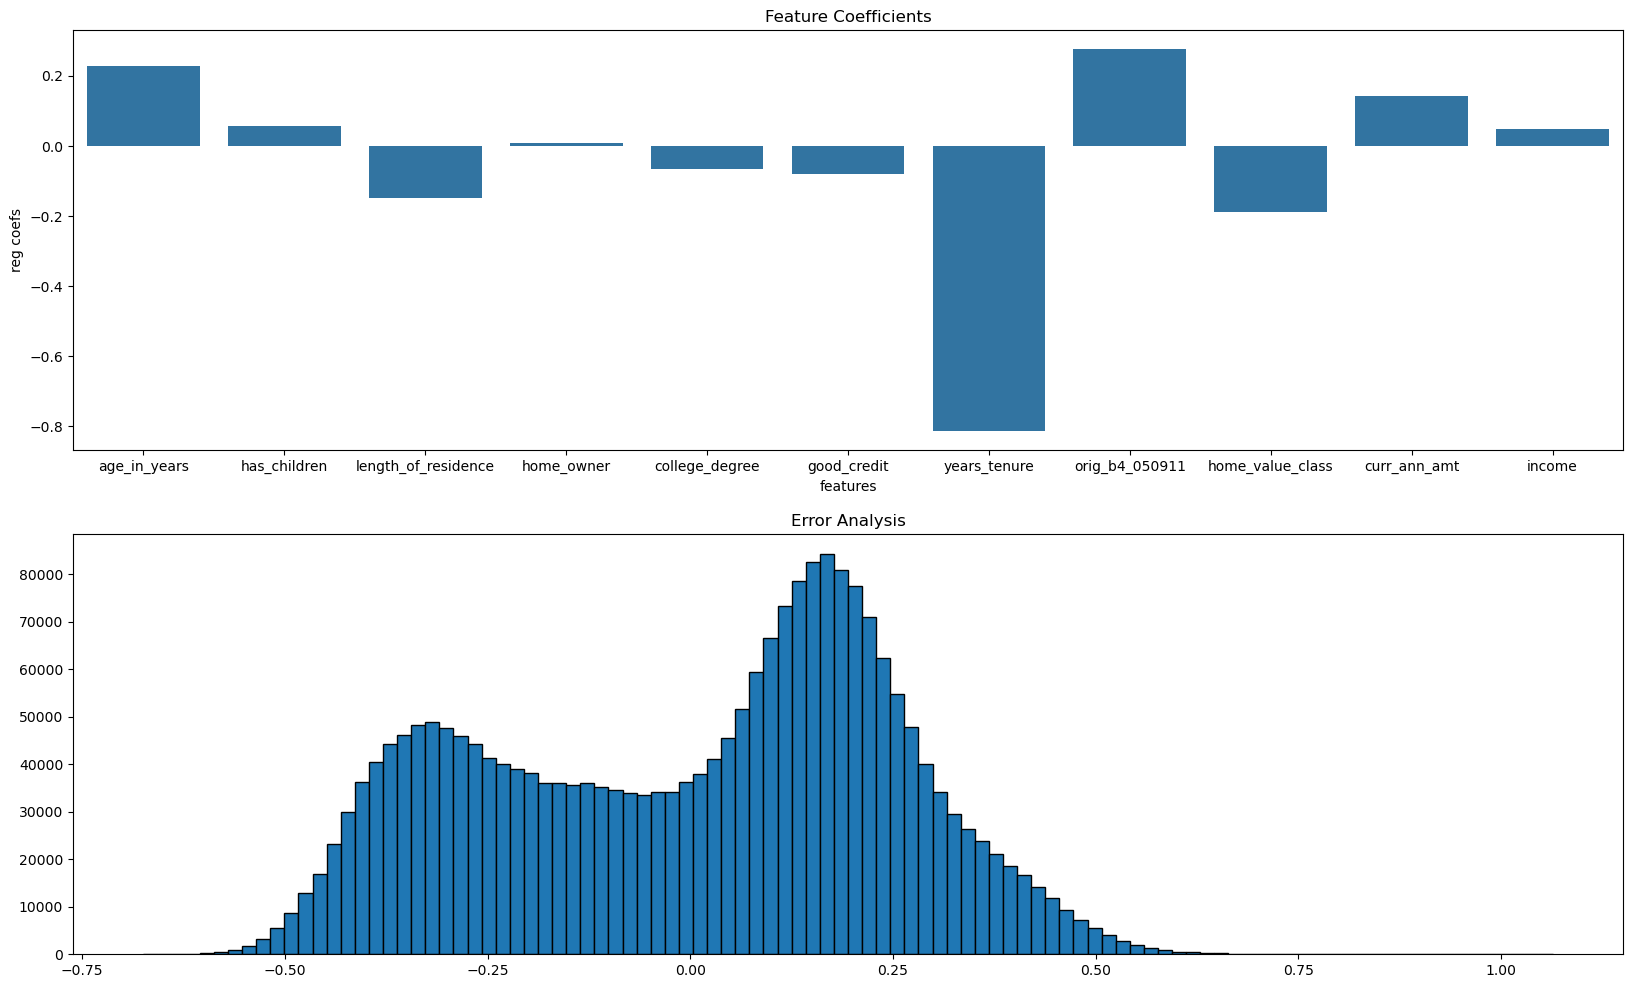

In [201]:
fig, axes = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(20, 12))

sns.barplot(pd.DataFrame({'features': list(reg_results_0.keys()), 'reg coefs': reg_results_0.values()}), x='features', y='reg coefs', ax=axes[0])
axes[0].set_title('Feature Coefficients')

axes[1].hist(dy_resampled, bins=100, edgecolor='black')
axes[1].set_title('Error Analysis')

plt.show()

In [233]:
# Now try to predict the testing data
X_test = X_test_b4use.copy()
X_test_b4use = X_test.copy()
X_test_dropped = X_test.copy()[['curr_ann_amt', 'income']]
X_test = X_test.drop(['curr_ann_amt', 'income'], axis=1)

X_test['curr_ann_amt'] = np.log(X_test_dropped['curr_ann_amt'].astype('float').values)
X_test['income'] = np.log(X_test_dropped['income'].astype('float').values)

y_proba_test = logit.predict_proba(X_test)[:,1]
y_proba_resampled = logit.predict_proba(X_resampled)[:,1]

auc_test = roc_auc_score(y_test, y_proba_test)
auc_resampled = roc_auc_score(y_resampled, y_proba_resampled)
logloss_test = log_loss(y_test, y_proba_test)
logloss_resampled = log_loss(y_resampled, y_proba_resampled)

metriks = np.array([logloss_resampled, logloss_test, auc_resampled, auc_test])[:,np.newaxis].transpose()

print(f"Train logloss and auc of are: {metriks[0,0]: .6f} and {metriks[0,2]: .6f}")
print(f"Test logloss and auc of are: {metriks[0,1]: .6f} and {metriks[0,3]: .6f}")

Train logloss and auc of are:  0.685420 and  0.567093
Test logloss and auc of are:  0.685581 and  0.566264


In [239]:
LassoCV = LogisticRegressionCV(Cs=[10000.0, 1.0, 0.1, 0.01, 0.001, 0.0001], cv=5, max_iter=1000, n_jobs=8, penalty='l1',
                     scoring='neg_log_loss', refit=True, solver='liblinear', verbose=20)
LassoCV.fit(X_resampled, y_resampled)
LassoCV

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.2min
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:  5.5min remaining:  3.7min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  5.5min finished


[LibLinear]

LogisticRegressionCV(Cs=[10000.0, 1.0, 0.1, 0.01, 0.001, 0.0001], cv=5,
                     max_iter=1000, n_jobs=8, penalty='l1',
                     scoring='neg_log_loss', solver='liblinear', verbose=20)

The best case goes with C = 1.0
Training accuracy, recall and precision: 0.499933, 0.998997 and 0.499925
Test accuracy, recall and precision: 0.500407, 0.998996 and 0.500401


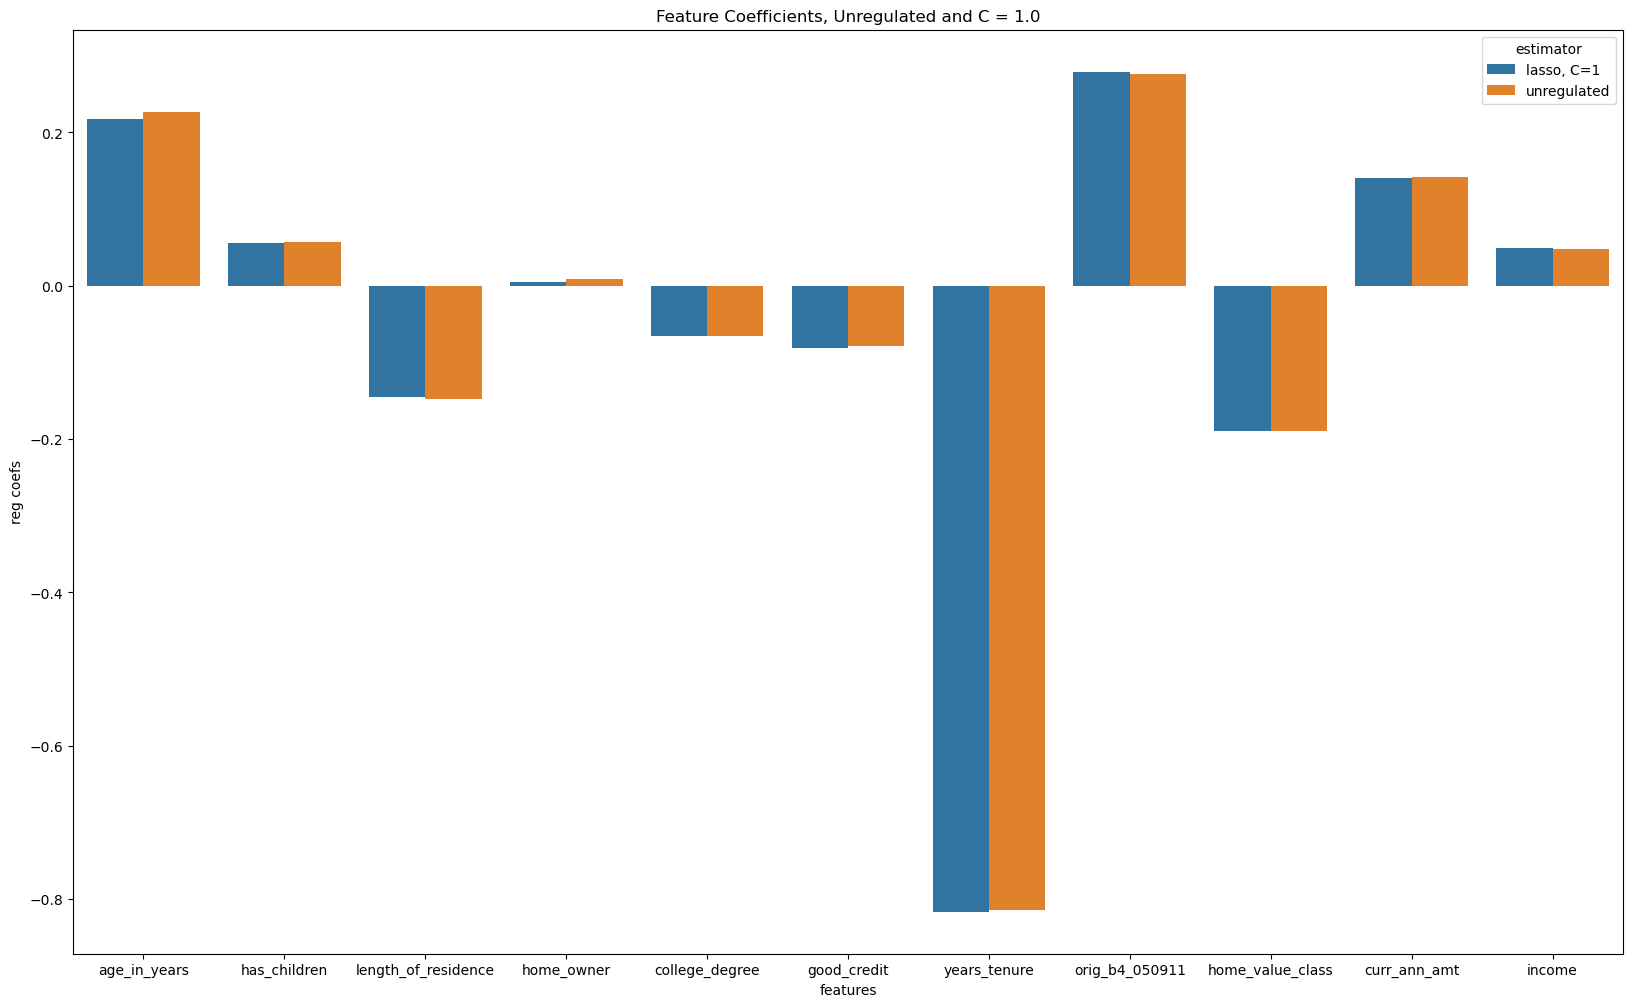

In [383]:
print(f"The best case goes with C = {LassoCV.C_[0]:.1f}")

fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 12))

dt_features = np.hstack((LassoCV.feature_names_in_, np.array(list(reg_results_0.keys()))))
dt_coefs = np.hstack((LassoCV.coef_[0,], np.array(list(reg_results_0.values()))))
dt_estimator = np.hstack((np.repeat('lasso, C=1', len(LassoCV.coef_[0,]), axis=0), np.repeat('unregulated', len(list(reg_results_0.values())), axis=0)))

dt_features.shape, dt_coefs.shape, dt_estimator.shape
sns.barplot(pd.DataFrame({'features': dt_features, 'reg coefs': dt_coefs, 'estimator': dt_estimator}), x='features', y='reg coefs', hue='estimator', ax=ax)
ax.set_title(f'Feature Coefficients, Unregulated and C = {LassoCV.C_[0]:.1f}')

# Now simulate accuracy and recall
def get_accuracy(yhat, y):
    T = (yhat == y).sum()
    return T/len(y)
def get_recall(yhat, y):
    TP = ((yhat == 1) & (y == 1)).sum()
    return TP/y.sum()
def get_precision(yhat, y):
    TP = ((yhat == 1) & (y == 1)).sum()
    return TP/yhat.sum()
def simulate_metrics(X_resampled, y_resampled, Nsim=1000):
    yhat_prob = LassoCV.predict_proba(X_resampled)
    accuracy_sim = np.zeros((Nsim,1))
    recall_sim = np.zeros((Nsim,1))
    precision_sim = np.zeros((Nsim,1))
    yhat = np.zeros((y_resampled.shape))
    for i in range(Nsim):  
        yhat[np.random.rand(len(y_resampled)) > yhat_prob[:,0].squeeze()] = 1
        accuracy_sim[i] = get_accuracy(yhat, y_resampled)
        recall_sim[i] = get_recall(yhat, y_resampled)
        precision_sim[i] = get_precision(yhat, y_resampled)
    accuracy_train_LassoLR = np.mean(accuracy_sim)
    recall_train_LassoLR = np.mean(recall_sim)
    precision_train_LassoLR = np.mean(precision_sim)
    return accuracy_train_LassoLR, recall_train_LassoLR, precision_train_LassoLR

accuracy_train_LassoLR, recall_train_LassoLR, precision_train_LassoLR = simulate_metrics(X_resampled, y_resampled)
print(f'Training accuracy, recall and precision: {accuracy_train_LassoLR:.6f}, {recall_train_LassoLR:.6f} and {precision_train_LassoLR:.6f}')

accuracy_test_LassoLR, recall_test_LassoLR, precision_test_LassoLR = simulate_metrics(X_test, y_test)
print(f'Test accuracy, recall and precision: {accuracy_test_LassoLR:.6f}, {recall_test_LassoLR:.6f} and {precision_test_LassoLR:.6f}')

In [ ]:
# OK Now use KNN approach on X
# knn_cv_params = {'n_neighbors': [4,5,6,7,8],
#                  'weights': ['uniform', 'distance'],
#                  'leaf_size': [20,25,30,35,40]}
knn_cv_params = {'n_neighbors': [5],
                 'weights': ['uniform'],
                 'leaf_size': [30]}
knn = KNeighborsClassifier()
knnCV = GridSearchCV(estimator=knn, param_grid=knn_cv_params, cv=5, scoring=['accuracy', 'recall'], refit='recall', n_jobs=1, verbose=3)
#knnCV.fit(X_resampled, y_resampled)